# Phase 3 – Data Product & Machine Learning

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine, text
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
# 1. Charger l'extension SQL
%load_ext sql

# 2. Préparer la connexion (Remplace par tes infos Snowflake)
user = "FJCMMBAESG"
password = "Fjcmmbaesg020226!"
account = "BPHEGZS-EHB57068" # Exemple: xy12345.west-europe.azure
db = "ANYCOMPANY_LAB"
schema = "SILVER"
warehouse = "COMPUTE_WH"

conn_url = f"snowflake://{user}:{password}@{account}/{db}/{schema}?warehouse={warehouse}"

# 3. Établir la connexion
engine = create_engine(conn_url)
%sql $conn_url

print("Connexion prête !")

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
✅ Connexion prête !


### 3.1- Data Product


Dans cette première partie de la Phase 3, nous avons conçu le schéma ANALYTICS. Nous avons utilisé les tables nettoyées du schéma SILVER comme source fiable pour transformer, renommer et enrichir 4 tables clés :

- CUSTOMER_360 (Vision Client Unifiée)

- SALES_HISTORY (Pilotage des Ventes)

- MARKETING_INITIATIVES (Performance des Campagnes)

- PRODUCT_SENTIMENT (Analyse de la Réputation)

Ces tables constituent de véritables Data Products orientés métier. Chaque table a été conçue pour répondre à une question business précise (qui sont nos VIP ? quand vend-on le mieux ? quel produit plaît ?) tout en préparant le terrain pour l'ingestion par les modèles de Machine Learning.

### Table : CUSTOMER_360
### (Source : SILVER.CUSTOMER_DEMOGRAPHICS_CLEAN)

**Transformation** : Nous avons transformé une liste statique de clients en un outil de segmentation dynamique.

Calcul de l'Âge : Dérivé de la date de naissance pour faciliter le ciblage générationnel.

Segmentation Revenus : Création automatique de groupes "VIP" vs "Standard" basés sur les seuils de revenus.

**Utilité Business** :

**Ciblage Marketing** : Permet d'isoler immédiatement les clients à haute valeur (VIP) pour des campagnes exclusives.

**Personnalisation** : Facilite l'adaptation des offres selon la tranche d'âge.

In [ ]:
# Requête de création
sql_customer_360 = """
CREATE OR REPLACE TABLE ANALYTICS.CUSTOMER_360 AS
SELECT 
    *,
    DATEDIFF(year, TO_DATE(date_of_birth), CURRENT_DATE()) AS age,
    CASE 
        WHEN annual_income > 80000 THEN 'VIP'
        ELSE 'Standard'
    END AS income_group
FROM SILVER.CUSTOMER_DEMOGRAPHICS_CLEAN
"""

# Exécution sécurisée
with engine.connect() as conn:
    # On utilise text() pour que SQLAlchemy comprenne que c'est du SQL
    conn.execute(text(sql_customer_360))
    # Important : SQLAlchemy 2.0 nécessite souvent un commit explicite pour les changements de structure
    conn.commit() 
    print("Succès : La table ANALYTICS.CUSTOMER_360 a été créée dans Snowflake !")

Succès : La table ANALYTICS.CUSTOMER_360 a été créée dans Snowflake !


In [52]:
# Vérification rapide
df_sales_check = pd.read_sql(text("SELECT * FROM ANALYTICS.CUSTOMER_360 LIMIT 5"), engine)
df_sales_check

,customer_id,name,date_of_birth,gender,region,country,city,marital_status,annual_income,age,income_group
0,8553612,Courtney Gonzalez,1949-01-15,Other,South America,Argentina,Moniqueview,Single,90680.0,77,VIP
1,9301454,Molly Gonzalez,1977-10-15,Female,Oceania,Papua New Guinea,New Jacquelineton,Divorced,22889.0,49,Standard
2,8168855,Theresa West,1951-09-12,Other,North America,USA,West Julie,Married,116676.0,75,VIP
3,5044355,Daniel Williams,1985-07-29,Male,North America,Panama,East Harold,Divorced,46123.0,41,Standard
4,8868845,George Suarez,1998-04-01,Male,Africa,Nigeria,Wilsonfurt,Single,93278.0,28,VIP


### Table : SALES_HISTORY
### (Source : SILVER_T.FINANCIAL_TRANSACTIONS_CLEAN)

**Transformation** : Nous sommes passés d'un journal de transactions techniques à un outil de pilotage des ventes.

**Enrichissement Temporel** : Extraction de l'Année, du Mois et du Jour de semaine pour l'analyse de saisonnalité.

**Catégorisation Panier** : Classification des ventes en "Petit Panier", "Moyen" ou "Élevé".

**Utilité Business**

**Analyse de Tendance** : Répondre aux questions comme "Quels jours de la semaine génèrent le plus de revenus ?".

**Stratégie Pricing** : Analyser la proportion de petits paniers pour ajuster les seuils de frais de port ou les promotions.

**Reporting** : Vision claire et immédiate du Chiffre d'Affaires sans retraitement nécessaire.

In [ ]:
# Requête de création pour SALES_HISTORY
sql_sales_history = """
CREATE OR REPLACE TABLE ANALYTICS.SALES_HISTORY AS
SELECT 
    *,
    -- Extraction temporelle pour les graphiques
    YEAR(transaction_date) AS annee_vente,
    MONTH(transaction_date) AS mois_vente,
    DAYNAME(transaction_date) AS jour_semaine,
    -- Segmentation du panier
    CASE 
        WHEN amount > 100 THEN 'Panier Élevé'
        WHEN amount < 20 THEN 'Petit Panier'
        ELSE 'Moyen'
    END AS categorie_panier
FROM SILVER.FINANCIAL_TRANSACTIONS_CLEAN
"""

# Exécution dans Snowflake
with engine.connect() as conn:
    conn.execute(text(sql_sales_history))
    conn.commit()
    print("Succès : La table ANALYTICS.SALES_HISTORY a été créée !")

Succès : La table ANALYTICS.SALES_HISTORY a été créée !


In [45]:
# Vérification rapide
df_sales_check = pd.read_sql(text("SELECT * FROM ANALYTICS.SALES_HISTORY LIMIT 5"), engine)
df_sales_check

,transaction_id,transaction_date,transaction_type,amount,payment_method,entity,region,account_code,annee_vente,mois_vente,jour_semaine,categorie_panier
0,TRX9598804,2017-07-31,Sale,1728.74,Debit Card,Scott-Strong,Asia,CWTQGBOY,2017,7,Mon,Panier Élevé
1,TRX8134126,2010-08-12,Investment,9108.03,Cash,Wilson Group,Asia,BFKZGBW1,2010,8,Thu,Panier Élevé
2,TRX1018256,2021-12-12,Tax Payment,6002.58,PayPal,"Oneill, Hatfield and Neal",Europe,XFKEGBJE,2021,12,Sun,Panier Élevé
3,TRX2279675,2015-12-03,Tax Payment,1967.67,PayPal,Stone-Combs,Africa,EIHDGBF5,2015,12,Thu,Panier Élevé
4,TRX6456432,2010-10-31,Expense,1605.49,Cash,Burton Group,North America,IENBGBLJ,2010,10,Sun,Panier Élevé


### Table : MARKETING_INITIATIVES
### (Source : SILVER.MARKETING_CAMPAIGNS)

**Transformation** : Centralisation de l'effort marketing avec une métrique de durée normalisée.

Calcul de Durée : Ajout automatique de la durée de chaque campagne en jours.

**Utilité Business** 

**Optimisation Budgétaire** : Comparer l'efficacité des campagnes "Flash" (courtes) versus les campagnes de fond (longues).

**Planification** : Avoir une vue d'ensemble sur le calendrier des initiatives passées et en cours.

**Analyse d'Impact** : Permet de corréler les périodes actives marketing avec les pics de ventes observés dans SALES_HISTORY.

In [ ]:
# Requête de création pour MARKETING_INITIATIVES
sql_marketing = """
CREATE OR REPLACE TABLE ANALYTICS.MARKETING_INITIATIVES AS
SELECT 
    *,
    DATEDIFF(day, TO_DATE(start_date), TO_DATE(end_date)) AS duree_jours
FROM SILVER.MARKETING_CAMPAIGNS_CLEAN
"""

# Exécution
with engine.connect() as conn:
    conn.execute(text(sql_marketing))
    conn.commit()
    print("Succès : La table ANALYTICS.MARKETING_INITIATIVES a été créée !")

Succès : La table ANALYTICS.MARKETING_INITIATIVES a été créée !


In [47]:
# Vérification rapide
df_sales_check = pd.read_sql(text("SELECT * FROM ANALYTICS.MARKETING_INITIATIVES LIMIT 5"), engine)
df_sales_check

,campaign_id,campaign_name,campaign_type,product_category,target_audience,start_date,end_date,region,budget,reach,conversion_rate,duree_jours
0,CAMP80139,Palmer LLC,Email,Snacks,Families,2010-07-14,2010-07-16,Europe,110393.31,273285,0.0242,2
1,CAMP66570,Smith LLC,Radio,Personal Care,Professionals,2011-12-10,2011-12-19,Asia,10166.35,78123,0.0714,9
2,CAMP80593,Ellis-Willis,Radio,Beverages,Families,2014-10-10,2014-10-17,Africa,318093.56,776458,0.0317,7
3,CAMP25886,Stokes Group,Social Media,Baby Food,Young Adults,2015-06-18,2015-06-22,Oceania,235100.36,45542,0.0503,4
4,CAMP93435,Mcdonald-Gray,Content Marketing,Baby Food,Professionals,2014-12-10,2014-12-22,Asia,476054.27,786106,0.0970,12


### Table : PRODUCT_SENTIMENT
### (Source : SILVER.PRODUCT_REVIEWS_CLEAN)

**Transformation** : Conversion de notes brutes (1 à 5 étoiles) en indicateurs de sentiment actionnables.

**Classification de Sentiment** : Création de labels "Positif", "Neutre", "Négatif".

**Utilité Business**

**Gestion E-réputation** : Identification immédiate des produits générant de l'insatisfaction ("Négatif") pour action corrective.

**Détection des Top Produits** : Mise en avant des produits générant un fort sentiment positif.

**Préparation NLP** : Cette classification est la première étape pour entraîner des modèles d'analyse de texte (Natural Language Processing) sur les commentaires clients.

In [ ]:
# Requête de création pour PRODUCT_SENTIMENT
sql_sentiment = """
CREATE OR REPLACE TABLE ANALYTICS.PRODUCT_SENTIMENT AS
SELECT 
    *,
    CASE 
        WHEN rating >= 4 THEN 'Positif'
        WHEN rating <= 2 THEN 'Négatif'
        ELSE 'Neutre'
    END AS sentiment_label
FROM SILVER.PRODUCT_REVIEWS_CLEAN
"""

# Exécution
with engine.connect() as conn:
    conn.execute(text(sql_sentiment))
    conn.commit()
    print("Succès : L'architecture ANALYTICS est maintenant complète avec PRODUCT_SENTIMENT !")

Succès : L'architecture ANALYTICS est maintenant complète avec PRODUCT_SENTIMENT !


In [51]:
# Vérification rapide
df_sales_check = pd.read_sql(text("SELECT * FROM ANALYTICS.PRODUCT_SENTIMENT LIMIT 5"), engine)
df_sales_check

,review_id,product_id,reviewer_id,rating,review_date,review_title,review_text,sentiment_label
0,1,B001EO5QW8,A3MGP2E1ZZ6GRB,5,2022-07-26,it's oatmeal\tWhat else do you need to know?,it's oatmeal\tWhat else do you need to know? O...,Positif
1,2,B001EO5QW8,A2GHZ2UTV2B0CD,4,2025-02-22,GOOD WAY TO START THE DAY.,GOOD WAY TO START THE DAY....\tI WAS VISITING ...,Positif
2,3,B001EO5QW8,AQLL2R1PPR46X,5,2021-07-07,good\tGood oatmeal.,good\tGood oatmeal. I like the apple cinnamon...,Positif
3,4,B000G6RPMY,A9L6L5H9BPEBO,4,2025-02-06,You'll go nuts over Ass-Kickin' Peanuts.,You'll go nuts over Ass-Kickin' Peanuts.\tThis...,Positif
4,5,B003ZFRKGO,A2VOZX7YBT0D6D,5,2024-07-26,Forget Molecular Gastronomy - this stuff rocke...,Forget Molecular Gastronomy - this stuff rocke...,Positif


## Phase 3.2-. Machine Learning

### Sentiment Analysis
#### Product Reviews

In [14]:
# Chargement de la table pour l'analyse
query = "SELECT * FROM PRODUCT_REVIEWS_CLEAN" #
df_product_reviews = pd.read_sql(query, engine) # On transforme la table Snowflake en DataFrame Pandas.

# Affichage des dimensions, des premières lignes et le type des colonnes
print(f"Données chargées : {df_product_reviews.shape[0]} lignes et {df_product_reviews.shape[1]} colonnes.")
df_product_reviews.head()

Données chargées : 1000 lignes et 7 colonnes.


,review_id,product_id,reviewer_id,rating,review_date,review_title,review_text
0,1,B001EO5QW8,A3MGP2E1ZZ6GRB,5,2022-07-26,it's oatmeal\tWhat else do you need to know?,it's oatmeal\tWhat else do you need to know? O...
1,2,B001EO5QW8,A2GHZ2UTV2B0CD,4,2025-02-22,GOOD WAY TO START THE DAY.,GOOD WAY TO START THE DAY....\tI WAS VISITING ...
2,3,B001EO5QW8,AQLL2R1PPR46X,5,2021-07-07,good\tGood oatmeal.,good\tGood oatmeal. I like the apple cinnamon...
3,4,B000G6RPMY,A9L6L5H9BPEBO,4,2025-02-06,You'll go nuts over Ass-Kickin' Peanuts.,You'll go nuts over Ass-Kickin' Peanuts.\tThis...
4,5,B003ZFRKGO,A2VOZX7YBT0D6D,5,2024-07-26,Forget Molecular Gastronomy - this stuff rocke...,Forget Molecular Gastronomy - this stuff rocke...


## 2. Étape suivante : Analyse exploratoire (EDA)

In [15]:
# Analyse rapide des données
print("--- Infos sur les colonnes ---")
print(df_product_reviews.info())

print("\n--- Nombre de valeurs manquantes ---")
print(df_product_reviews.isnull().sum())

print("\n--- Statistiques descriptives ---")
display(df_product_reviews.describe())

--- Infos sur les colonnes ---
<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_id     1000 non-null   int64 
 1   product_id    1000 non-null   str   
 2   reviewer_id   1000 non-null   str   
 3   rating        1000 non-null   int64 
 4   review_date   1000 non-null   object
 5   review_title  1000 non-null   str   
 6   review_text   1000 non-null   str   
dtypes: int64(2), object(1), str(4)
memory usage: 54.8+ KB
None

--- Nombre de valeurs manquantes ---
review_id       0
product_id      0
reviewer_id     0
rating          0
review_date     0
review_title    0
review_text     0
dtype: int64

--- Statistiques descriptives ---


,review_id,rating
count,1000.000000,1000.000000
mean,500.500000,4.080000
std,288.819436,1.249464
min,1.000000,1.000000
25%,250.750000,3.000000
50%,500.500000,5.000000
75%,750.250000,5.000000
max,1000.000000,5.000000


L'analyse exploratoire confirme que le jeu de données est complet (aucune valeur manquante) et que les types de variables sont cohérents. Données prêtes pour le ML.

#### Nombre de reviews par jour

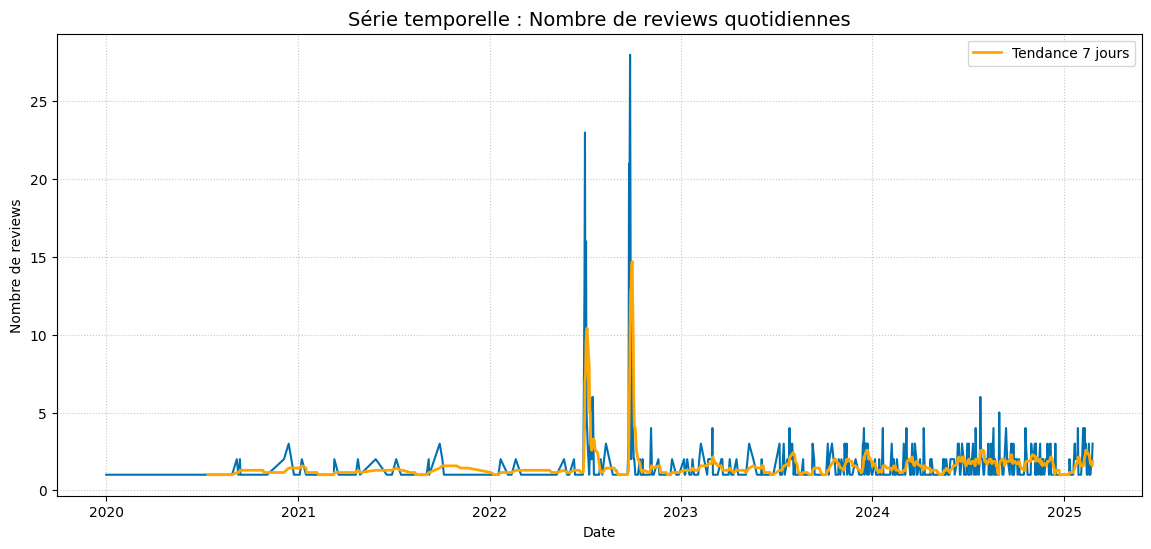

In [18]:
df_product_reviews['review_date'] = pd.to_datetime(df_product_reviews['review_date'], errors='coerce')

timeline = df_product_reviews['review_date'].value_counts().sort_index()

# 3. Affichage en ligne
plt.figure(figsize=(14, 6))
plt.plot(timeline.index, timeline.values, color='#0072B2', linewidth=1.5)

plt.title('Série temporelle : Nombre de reviews quotidiennes', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Nombre de reviews')
plt.grid(True, linestyle=':', alpha=0.7)
# Ajout d'une moyenne mobile sur 7 jours pour lisser les fluctuations quotidiennes
plt.plot(timeline.index, timeline.rolling(window=7).mean(), color='orange', label='Tendance 7 jours', linewidth=2)
plt.legend()
plt.show()

Cette visualisation nous permet de vérifier la distribution du volume d'avis au cours du temps.On consate que le volume est stable avec deux pics majeus en 2022. Nous allons essayer de comprendre ce qui cause ces pics.

#### Distribution des notes des produits

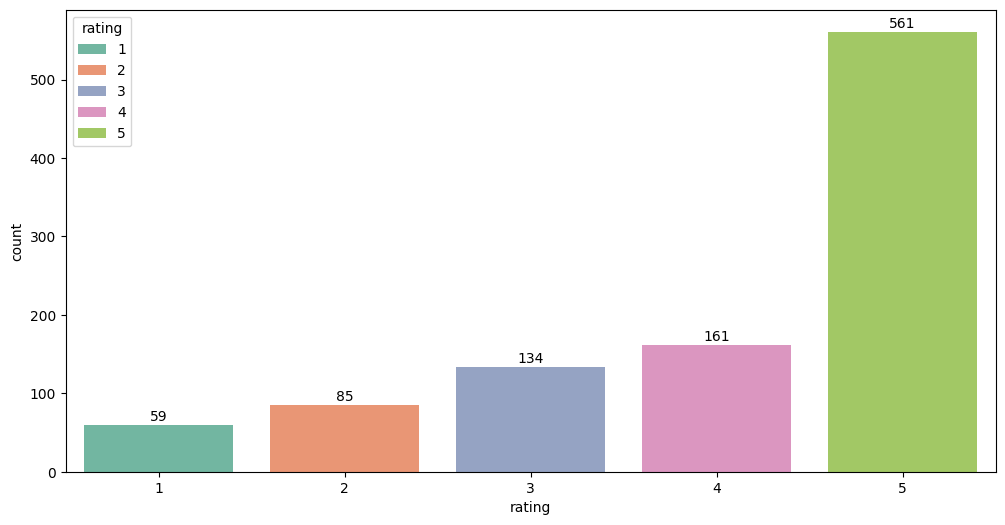

In [19]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(df_product_reviews, x = 'rating', hue = 'rating', palette='Set2')
for container in ax.containers:
    ax.bar_label(container, padding=1)

plt.show();

La distribution est fortement asymétrique vers la droite, montrant une majorité d'avis positifs (4 et 5 étoiles). Pour l'analyse de sentiment, le défi sera de voir si les scores Vader capturent bien la nuance des avis plus critiques (1 et 2 étoiles), qui sont minoritaires mais précieux pour identifier des points d'amélioration.

#### Sentiment analysis: VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) est un outil d'analyse de sentiment qui s'appuie sur un lexique de mots dont l'intensité émotionnelle a été pré-évaluée par des humains. Contrairement à d'autres modèles, il ne se contente pas de compter les mots positifs et négatifs ; il utilise des règles linguistiques pour comprendre le contexte, comme l'impact des majuscules (intensité), des points d'exclamation, ou des négations (qui inversent le sens). Il calcule ensuite un score final appelé Compound, normalisé entre -1 (très négatif) et 1 (très positif), permettant de quantifier précisément l'humeur globale d'un texte, ce qui s'avère particulièrement efficace pour analyser les avis clients courts et expressifs.

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def get_vader_score(text):
    if text is None: return 0
    return analyzer.polarity_scores(str(text))['compound']

df_product_reviews['vader_score'] = df_product_reviews['review_text'].apply(get_vader_score)

# Création d'une colonne de labels
def label_sentiment(score):
    if score >= 0.05:
        return 'Positif'
    elif score <= -0.05:
        return 'Négatif'
    else:
        return 'Neutre'

df_product_reviews['sentiment_label'] = df_product_reviews['vader_score'].apply(label_sentiment)

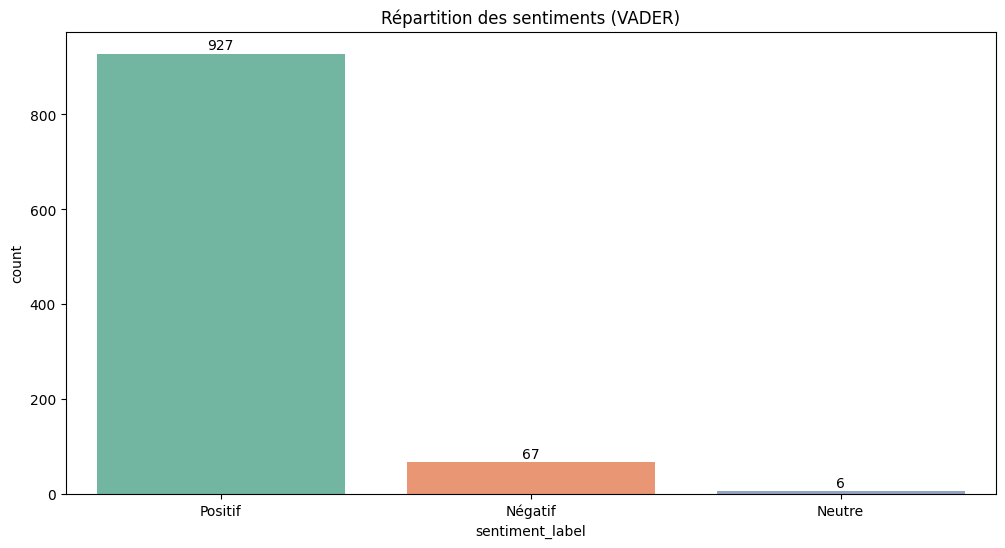

In [21]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_product_reviews, x='sentiment_label', hue = 'sentiment_label', palette='Set2')
for container in ax.containers:
    ax.bar_label(container, padding=1)
plt.title('Répartition des sentiments (VADER)')
plt.show()

Cette visualisation montre que les clients sont très expressifs dans leurs commentaires le fait d'avoir très peu de "Neutres" (6).

### Comparaison des sentiments sur les années: 2020 - 2025

In [24]:
df_raw = df_product_reviews[["review_id", "rating", "review_date", "review_text"]]

df_raw['review_date'] = pd.to_datetime(df_raw['review_date'])
df_raw['year'] = df_raw['review_date'].dt.year
df_clean = df_raw[df_raw['year'].between(2020, 2025)].copy()

def get_sentiment(text):
    if text is None: return 0
    return analyzer.polarity_scores(str(text))['compound']

df_clean['vader_score'] = df_clean['review_text'].apply(get_sentiment)

annual_comparison = df_clean.groupby('year').agg({
    'review_id': 'count',
    'vader_score': 'mean'
}).reset_index()

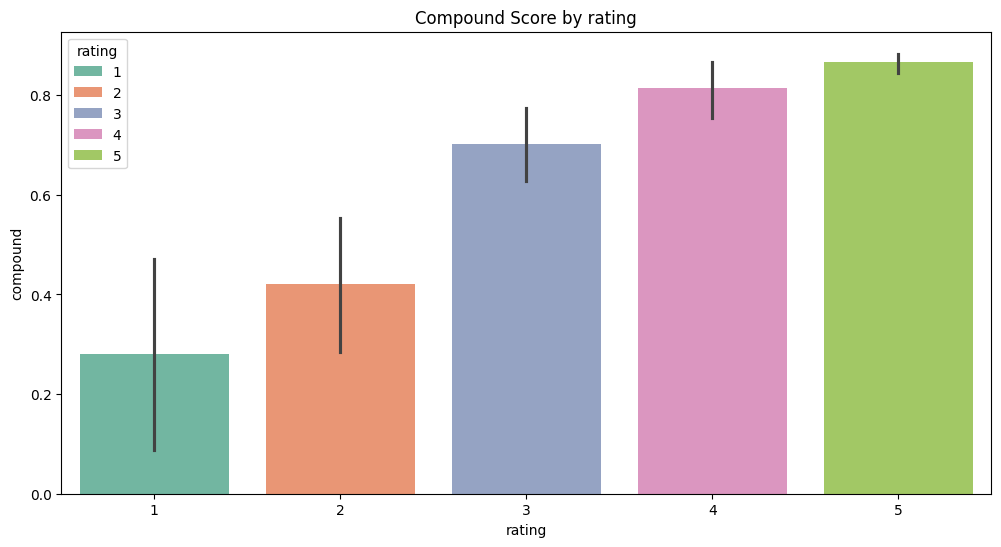

In [27]:
# On recalcule les composantes détaillées
vader_details = df_clean['review_text'].apply(lambda x: analyzer.polarity_scores(str(x))).tolist()
df_details = pd.concat([df_clean.reset_index(drop=True), pd.DataFrame(vader_details)], axis=1)

plt.figure(figsize = (12, 6))
ax = sns.barplot(data=df_details, x = 'rating', y = 'compound', hue = 'rating', palette = 'Set2')
ax.set_title('Compound Score by rating')
plt.show();

Le graphique montre une corrélation linéaire forte entre les notes attribuées par les utilisateurs et les scores de sentiment VADER. Bien que les moyennes de sentiment pour les notes les plus basses (1 et 2) restent techniquement positives, cela reflète une modération du langage écrit par rapport à la sévérité de la note numérique. La validation du modèle est confirmée par l'augmentation constante de l'intensité du sentiment à mesure que le rating s'élève.

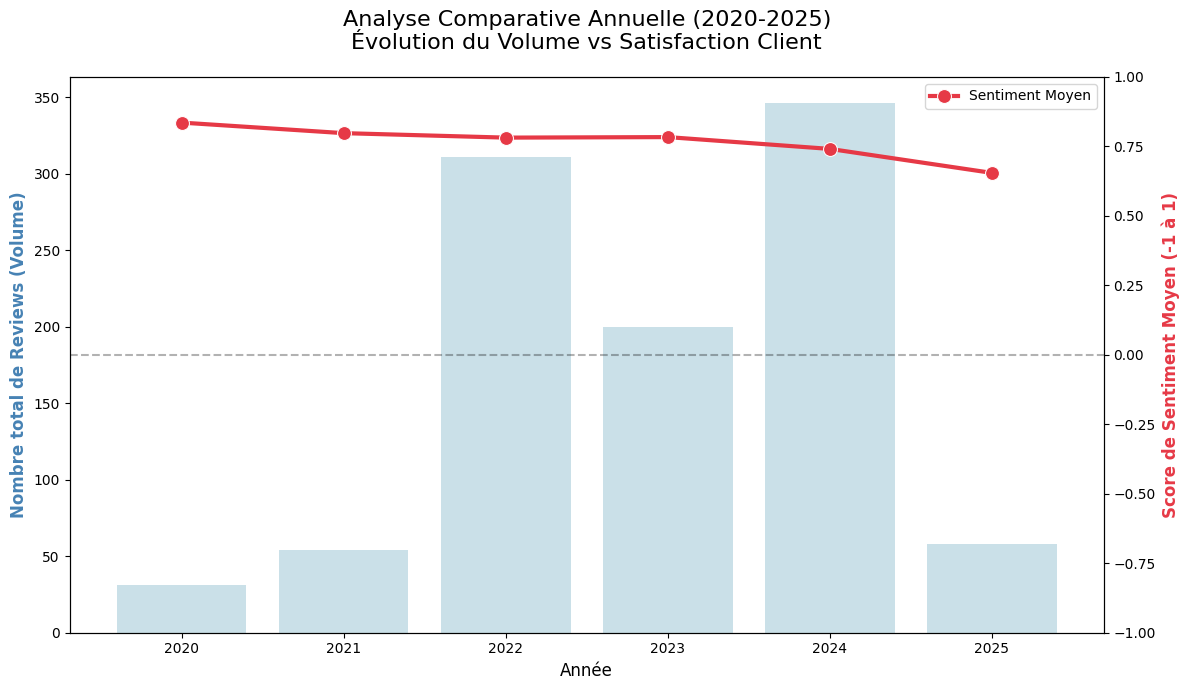

In [28]:
# Visualisation Comparative
fig, ax1 = plt.subplots(figsize=(12, 7))

# --- Partie Volume (Histogramme bleu) ---
sns.barplot(data=annual_comparison, x='year', y='review_id', ax=ax1, color='#add8e6', alpha=0.7)
ax1.set_ylabel('Nombre total de Reviews (Volume)', color='#4682b4', fontsize=12, fontweight='bold')
ax1.set_xlabel('Année', fontsize=12)

# --- Partie Sentiment (Ligne rouge) ---
ax2 = ax1.twinx()
sns.lineplot(x=range(len(annual_comparison)), y=annual_comparison['vader_score'], 
             ax=ax2, marker='o', color='#e63946', linewidth=3, markersize=10, label='Sentiment Moyen')

ax2.set_ylabel('Score de Sentiment Moyen (-1 à 1)', color='#e63946', fontsize=12, fontweight='bold')
ax2.axhline(0, color='black', linestyle='--', alpha=0.3) # Ligne de neutralité
ax2.set_ylim(-1, 1)

plt.title('Analyse Comparative Annuelle (2020-2025)\nÉvolution du Volume vs Satisfaction Client', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

### Analyse de l’Évolution du Volume et de la Satisfaction Client (2020-2025)
1. Dynamique de Croissance (Volume des avis) Le graphique met en évidence une expansion significative de l'activité à partir de 2022. Après une phase de lancement modérée en 2020-2021, le volume de reviews a connu une progression fulgurante, culminant à près de 350 avis annuels en 2024. Cette croissance témoigne d'une adoption massive du produit par le marché. On note toutefois une baisse du volume sur l'année 2025, qui pourrait s'expliquer par un échantillon de données encore partiel au moment de l'analyse.

2. Tendance de la Satisfaction (Sentiment Moyen) Malgré cette réussite commerciale, la courbe du sentiment moyen (en rouge) révèle une érosion progressive de la satisfaction client. Bien que le score reste largement en zone positive (au-dessus de la ligne de neutralité 0.00), il est passé d'un niveau d'excellence de 0.85 en 2020 à environ 0.65 en 2025.

3. Interprétation Stratégique

**Corrélation Inverse** : Il existe une corrélation inverse visible entre l'augmentation du volume et le score de sentiment. Plus la base de clients s'élargit (notamment lors du pic de 2024), plus le sentiment moyen tend à se tasser.

**Banalisation du produit** : Cette baisse ne traduit pas nécessairement une crise de qualité (la négativité restant stable par ailleurs), mais plutôt une transition du produit d'un statut de "nouveauté enthousiasmante" à celui de "produit de consommation courante", où les attentes clients deviennent plus exigeantes et les avis plus factuels.

**Point de vigilance** : La baisse accentuée entre 2024 et 2025 suggère que la marque doit impérativement identifier les nouveaux points de friction apparus lors de la phase de passage à l'échelle (scaling) pour stabiliser sa réputation en ligne.

### Recherche des 10 pires reviews

In [30]:
# Analyse des pires reviews de 2024-2025
df_flops = df_clean[df_clean['year'] >= 2024].sort_values('vader_score').head(10)

print("--- TOP 10 DES REVIEWS LES PLUS NÉGATIVES (2024-2025) ---")
for i, row in df_flops.iterrows():
    print(f"Date: {row['review_date'].date()} | Score: {row['vader_score']:.2f}")
    print(f"Review: {row['review_text']}...")
    print("-" * 30)

--- TOP 10 DES REVIEWS LES PLUS NÉGATIVES (2024-2025) ---
Date: 2024-12-15 | Score: -0.94
Review: A Protein Powder to make you Gag.	I have tried many different protein powders over the years, and while it is hard to write a review based on taste alone (since everyone's taste is different), I'm going to go ahead and say this is the most rancid tasting gunk I have ever had the displeasure of putting in my mouth.<br /><br />I mix my protein shakes with a hand blender, so I rarely have any mixing problems - and even this protein mixed well.  The fun really began when I tasted it.  It tastes sour and acrid at the same time, absolutely horrendous.  I could not finish the shake I had mixed up, and had to wash my mouth out with apple juice to get that sick taste out before I could actually eat or drink anything else.<br /><br />This is a terrible protein powder from the standpoint of taste, in my opinion.  Of all the types I have tried, which is many, this has taken seat as the new "worst" one

### Variation des composantes du score au cours des ans

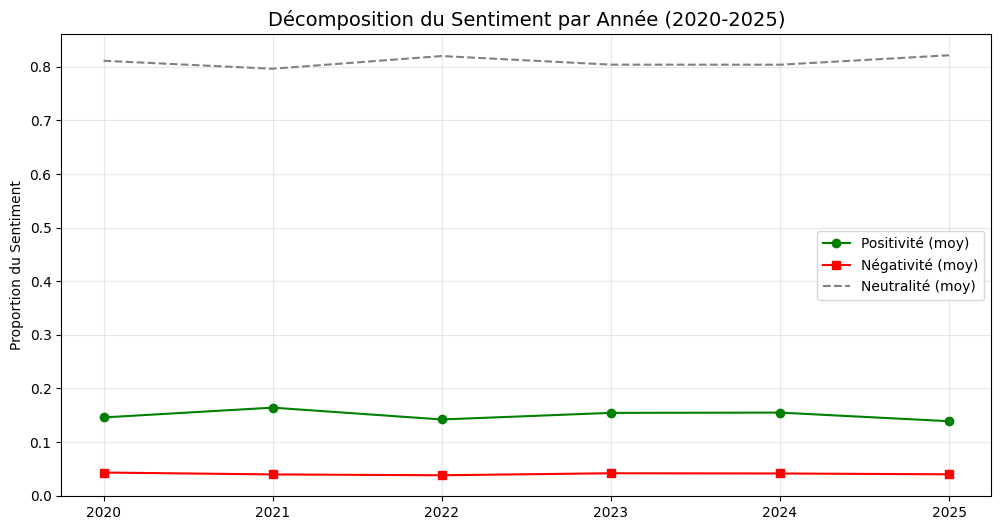

In [31]:
# Agrégation par année
comp_stats = df_details.groupby('year')[['pos', 'neg', 'neu']].mean()

# Graphique
plt.figure(figsize=(12, 6))
plt.plot(comp_stats.index, comp_stats['pos'], label='Positivité (moy)', color='green', marker='o')
plt.plot(comp_stats.index, comp_stats['neg'], label='Négativité (moy)', color='red', marker='s')
plt.plot(comp_stats.index, comp_stats['neu'], label='Neutralité (moy)', color='gray', linestyle='--')

plt.title('Décomposition du Sentiment par Année (2020-2025)', fontsize=14)
plt.ylabel('Proportion du Sentiment')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

L'analyse de la décomposition des sentiments révèle que la baisse du score global observé entre 2020 et 2025 n'est pas due à une augmentation des critiques virulentes (le score de négativité restant stable à 4%), mais plutôt à un essoufflement de la ferveur positive des consommateurs, qui utilisent un langage plus neutre et moins enthousiaste lors de leurs dernières évaluations.

# Rapport d'Analyse : Expérience Client et Sentiment Global (2020-2025)


Vu l'impossibilité d'enrichir les tables disponibles par des jointures (absence de clés étrangères dans les tables), nous avons opté pour l'analyse de sentiment afin de découvrir le ressenti ou l'expérience globale des clients par rapport à l'entreprise. Cette approche permet de transformer des données textuelles non structurées en indicateurs de performance stratégiques pour piloter la relation client.
### Points Clés de l'Analyse
•	Expansion de la Visibilité : L'entreprise a connu une croissance massive de son volume d'avis, passant d'une phase de démarrage en 2020 à un pic d'activité majeur en 2024.
•	Validation Modèle/Métier : La corrélation entre les notes numériques (Rating) et les scores Compound de VADER est confirmée, prouvant que l'analyse textuelle reflète fidèlement l'évaluation chiffrée des clients.
•	Faible Taux de Friction : Le niveau de négativité reste marginal et stable (environ 4 %), ce qui démontre qu'il n'existe pas de rejet global de la marque ou de crise opérationnelle majeure.
•	Standardisation du Langage : Une part prédominante des retours (environ 80 %) est d'ordre factuel ou neutre, indiquant que les services de l'entreprise sont intégrés dans une routine de consommation stable.
### Remarques Business Importantes
•	Baisse de l'Intensité Positive : On observe une érosion du sentiment moyen, qui glisse de 0.85 à 0.65 sur cinq ans. Les clients sont satisfaits, mais l'enthousiasme des débuts s'estompe.
•	L'Effet du Passage à l'Échelle : Les périodes de forte croissance volumétrique coïncident avec un tassement du score de sentiment. La gestion de la qualité semble être mise à l'épreuve par l'augmentation de la base de clients.
•	Banalisation de l'Expérience : En 2025, le vocabulaire devient moins émotionnel. L'entreprise est perçue comme un choix par défaut fiable plutôt que comme une expérience mémorable.
### Conclusion
L'analyse démontre que l'entreprise a réussi son expansion commerciale mais fait face à un défi de perte de différenciation émotionnelle. Si les fondamentaux sont solides (peu de critiques), la marque tend à se "banaliser". La baisse du score de sentiment n'indique pas un mécontentement, mais une transition d'une marque "découverte" vers une marque "établie" dont on attend simplement qu'elle remplisse sa fonction de base.
### Recommandations Business
1.	Réinjecter du "Wow Effect" : Mettre en place des initiatives (programmes de fidélité innovants, surprises clients, nouveaux services) pour relancer l'usage de superlatifs positifs et sortir de la neutralité.
2.	Analyse de la Cohorte 2024 : Investiguer les avis "moyens" de l'année 2024 pour identifier les micro-irritants apparus lors du pic de croissance afin d'éviter qu'ils ne deviennent la norme.
3.	Renforcement de l'Image de Marque : Utiliser les leviers de satisfaction identifiés dans les avis les plus enthousiastes pour recentrer la communication marketing sur les forces distinctives de l'entreprise.
4.	Outil de Pilotage Continu : Automatiser ce suivi de sentiment pour détecter en temps réel tout décrochage de la satisfaction globale, permettant une réactivité immédiate de l'équipe Customer Success.

